# Imports, install and mount

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# my_local_drive='/content/gdrive/MyDrive/SL2024/datas'
# # Ajout du path pour les librairies, fonctions et données
# sys.path.append(my_local_drive)
# # Se positionner sur le répertoire associé
# %cd $my_local_drive
# %pwd
# print("DRIVE MOUNTED")

In [2]:
! pip install cuda
! pip install torch_geometric
! pip install dgl

import torch
import torch.optim as optim
import os.path as osp
from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
import pandas as pd
from tqdm import tqdm
from torch_geometric.loader import DataLoader
import dgl
import os


Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement cuda (from versions: none)
ERROR: No matching distribution found for cuda
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/elliot/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # Tip : Use cpu for debugging
print(device)

cuda


# TSV to pyg.Data

We want :
- x (tensorised and processed node attributes) (1 for now)
- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
- edge_attr (a tensor that indicate the type of each edge)
- y (edge labels - optional, can be defined as node labels if needed)

## Reading and mapping graph

What we want : Create a Data object with all the properties I want to use later

	- x (tensorised and processed node attributes) (Not for now)
	- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
	- y (desired edge labels - optional, can be defined as node labels if needed) (Not for now)
	- any other things you want to use later

In [40]:
file_path = "/home/elliot/Desktop/StageM2/data/iric/little_iric.tsv"
iric = pd.read_csv(file_path, delimiter='\t')
display(iric)

# Mapping entities to ids

entity_set = set(iric['object']).union(set(iric['subject']))
entity_to_mapping = {entity: i for i, entity in enumerate(entity_set)}
relation_set = set(iric['predicate'])
relation_to_mapping = {relation: i for i, relation in enumerate(relation_set)}

mapped_iric = iric.copy()
mapped_iric['object'] = mapped_iric['object'].apply(lambda x: entity_to_mapping[x])
mapped_iric['subject'] = mapped_iric['subject'].apply(lambda x: entity_to_mapping[x])
mapped_iric['predicate'] = mapped_iric['predicate'].apply(lambda x: relation_to_mapping[x])

display(mapped_iric)


print("Minima in mappings :")
print('subject :', min(mapped_iric['subject']))
print('predicate :',min(mapped_iric['predicate']))
print('object :',min(mapped_iric['object']))

print(entity_to_mapping)
print(relation_to_mapping)

mapping_to_entity = {v: k for k, v in entity_to_mapping.items()}
mapping_to_relation = {v: k for k, v in relation_to_mapping.items()}
print(mapping_to_entity)
print(mapping_to_relation)

,subject,predicate,object
0,GO:0000001,is_a,GO:0048311
1,GO:0000001,is_a,GO:0048308
2,GO:0000002,is_a,GO:0007005
3,GO:0000003,is_a,GO:0008150
4,GO:0000006,is_a,GO:0005385
...,...,...,...
9994,GO:0009920,is_a,GO:0000919
9995,GO:0009920,is_a,GO:1903047
9996,GO:0009921,is_a,GO:0098797
9997,GO:0009922,is_a,GO:0016747


,subject,predicate,object
0,7284,0,7471
1,7284,0,4389
2,8475,0,6982
3,2172,0,2077
4,7666,0,1385
...,...,...,...
9994,5820,0,2066
9995,5820,0,6579
9996,7340,0,1958
9997,7596,0,8658


Minima in mappings :
subject : 0
predicate : 0
object : 3
{'GO:0008836': 0, 'GO:0002620': 1, 'GO:0002870': 2, 'GO:0071174': 3, 'GO:0060351': 4, 'GO:0070525': 5, 'GO:0008736': 6, 'GO:0008553': 7, 'GO:0007132': 8, 'GO:0008411': 9, 'GO:0006397': 10, 'GO:0005183': 11, 'GO:0007292': 12, 'GO:0006690': 13, 'GO:0010833': 14, 'GO:0006052': 15, 'GO:0009208': 16, 'GO:0019908': 17, 'GO:0004489': 18, 'GO:0002525': 19, 'GO:0009439': 20, 'GO:0003053': 21, 'GO:0007476': 22, 'GO:0009379': 23, 'GO:0034483': 24, 'GO:0003427': 25, 'GO:0019932': 26, 'GO:0001680': 27, 'GO:0006170': 28, 'GO:0035883': 29, 'GO:0002445': 30, 'GO:0009751': 31, 'GO:0009057': 32, 'GO:0002019': 33, 'GO:0000379': 34, 'GO:0006962': 35, 'GO:1901661': 36, 'GO:0002064': 37, 'GO:0006122': 38, 'GO:0017111': 39, 'GO:0009436': 40, 'GO:0008525': 41, 'GO:0009782': 42, 'GO:0006790': 43, 'GO:0007403': 44, 'GO:0046402': 45, 'GO:0009894': 46, 'GO:0002513': 47, 'GO:0009679': 48, 'GO:0046474': 49, 'GO:0006098': 50, 'GO:0099512': 51, 'GO:0000940': 5

## Building init vars for Data :

In [5]:
# # Initial nodes states :
# x = torch.ones(len(entity_set), 1)  # Chaque nœud a 1 pour état initial
# print('X : \n',x)

# Edges index
heads = list(mapped_iric['subject'])
tails = list(mapped_iric['object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
print('\nEDGE INDEX : \n',edge_index)

# edges states
edge_attributes = torch.tensor(mapped_iric['predicate'])
print('\nEDGES ATTRIBUTES : \n',edge_attributes)

iric_pyg = Data(
                # x = x,
                num_nodes = len(entity_set),
                edge_index = edge_index,
                edge_attr = edge_attributes)
print('\nDATASET :\n',iric_pyg)


print("\nDataset looks valid ? \n",iric_pyg.validate(raise_on_error=True))


EDGE INDEX : 
 tensor([[7284, 7284, 8475,  ..., 7340, 7596, 7964],
        [7471, 4389, 6982,  ..., 1958, 8658, 1137]])

EDGES ATTRIBUTES : 
 tensor([0, 0, 0,  ..., 0, 0, 0])

DATASET :
 Data(edge_index=[2, 9999], edge_attr=[9999], num_nodes=8859)

Dataset looks valid ? 
 True


# Setting up datas and model


## Splitting dataset

In [6]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected=False,
                            add_negative_train_samples=False,
                            )

train_data, val_data, test_data = transform(iric_pyg)

print(f"Hole Dataset :\n {iric_pyg}\n\nTrain:\n{train_data}\n\nTest :\n{test_data}\n\nValidation :\n{val_data}")
# Il ne faut pas regarder num_edges parce que RLS cache les arêtes mais ne les sort pas du graph.
# print(f"Number of edges in datasets : \n  Hole Dataset : {iric_pyg.num_edges}\n\n  Train: {train_data.num_edges}\n\n  Test : {test_data.num_edges}\n\n  Validation : {val_data.num_edges}")
print(f"Number of edges in datasets : \n  Train: {list(train_data.edge_label.size())[0]}\n\n  Test : {list(test_data.edge_label.size())[0]}\n\n  Validation : {list(val_data.edge_label.size())[0]}")

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print('\n\n',train_data.num_nodes)
print(train_data.num_edge_types)
print(train_data.__dict__)
print(train_data.edge_index[0].size())
print(train_data.edge_index[1].size())
print(train_data.edge_attr.size())
print(train_data.edge_attr)
print(train_data.num_nodes)
print(train_data.edge_index.size()[1])

Hole Dataset :
 Data(edge_index=[2, 9999], edge_attr=[9999], num_nodes=8859)

Train:
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=8859, edge_label=[8001], edge_label_index=[2, 8001])

Test :
Data(edge_index=[2, 9000], edge_attr=[9000], num_nodes=8859, edge_label=[1998], edge_label_index=[2, 1998])

Validation :
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=8859, edge_label=[1998], edge_label_index=[2, 1998])
Number of edges in datasets : 
  Train: 8001

  Test : 1998

  Validation : 1998




 8859
1
{'_edge_attr_cls': <class 'torch_geometric.data.data.DataEdgeAttr'>, '_tensor_attr_cls': <class 'torch_geometric.data.data.DataTensorAttr'>, '_store': {'edge_index': tensor([[3324, 1225, 5195,  ..., 6881, 6640, 2627],
        [1447,  544, 4822,  ..., 7028, 6787, 4363]], device='cuda:0'), 'edge_attr': tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'), 'num_nodes': 8859, 'edge_label': tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0'), 'edge_label_index': tensor([[3324, 1225, 5195,  ..., 6881, 6640, 2627],
        [1447,  544, 4822,  ..., 7028, 6787, 4363]], device='cuda:0')}}
torch.Size([8001])
torch.Size([8001])
torch.Size([8001])
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
8859
8001


## Iniating model

In [7]:
hidden_channels = 30
batch_size = 4096

model = ComplEx(
    num_nodes=train_data.num_nodes,
    # num_relations=train_data.num_edge_types,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

head_index = train_data.edge_index[0]
tail_index = train_data.edge_index[1]
rel_type = train_data.edge_attr

loader = model.loader(
    head_index = head_index,
    tail_index = tail_index,
    rel_type = rel_type,
    batch_size=batch_size,
    shuffle=True,
    # neg_sampling = 4
)

optimizer = optim.Adam(model.parameters(),
                      #  lr=0.01, weight_decay=1e-6
                       )

# Training and testing ComplEx

In [8]:
@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=test_data.edge_index[0],
        tail_index=test_data.edge_index[1],
        rel_type=test_data.edge_attr,
        batch_size=1000,
        k=10,
    )

def train():
    model.train()
    total_loss = total_examples = 0

    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

In [53]:
torch.set_grad_enabled(True)
model.to(device)

model.reset_parameters()


start_rank, start_mrr, start_hits_at_10 = test(test_data)
print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')

losses = []
for epoch in range(1, 100):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 500 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}',
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data)

print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')
print(f'Final Test Mean Rank: {rank:.2f}, Final Test MRR: {mrr:.4f}, '
      f'Final Test Hits@10: {hits_at_10:.4f}')

torch.set_grad_enabled(False)

100%|██████████| 9000/9000 [00:29<00:00, 301.88it/s]


Start Test Mean Rank: 4466.25, Start Test MRR: 0.0011, Start Test Hits@10: 0.0012
Epoch: 001, Loss: 4.0046
Epoch: 002, Loss: 3.8792
Epoch: 003, Loss: 3.7516
Epoch: 004, Loss: 3.6157
Epoch: 005, Loss: 3.5123
Epoch: 006, Loss: 3.3070
Epoch: 007, Loss: 3.1512
Epoch: 008, Loss: 2.9764
Epoch: 009, Loss: 2.8935
Epoch: 010, Loss: 2.7974
Epoch: 011, Loss: 2.7151
Epoch: 012, Loss: 2.5796
Epoch: 013, Loss: 2.4139
Epoch: 014, Loss: 2.4020
Epoch: 015, Loss: 2.3278
Epoch: 016, Loss: 2.2888
Epoch: 017, Loss: 2.2334
Epoch: 018, Loss: 2.1538
Epoch: 019, Loss: 2.1075
Epoch: 020, Loss: 2.0013
Epoch: 021, Loss: 1.9520
Epoch: 022, Loss: 1.9823
Epoch: 023, Loss: 1.9298
Epoch: 024, Loss: 1.8889
Epoch: 025, Loss: 1.8543
Epoch: 026, Loss: 1.7872
Epoch: 027, Loss: 1.7900
Epoch: 028, Loss: 1.7766
Epoch: 029, Loss: 1.7281
Epoch: 030, Loss: 1.7366
Epoch: 031, Loss: 1.7449
Epoch: 032, Loss: 1.6731
Epoch: 033, Loss: 1.6301
Epoch: 034, Loss: 1.6340
Epoch: 035, Loss: 1.6064
Epoch: 036, Loss: 1.6127
Epoch: 037, Loss: 

100%|██████████| 9000/9000 [00:30<00:00, 299.28it/s]

Start Test Mean Rank: 4466.25, Start Test MRR: 0.0011, Start Test Hits@10: 0.0012
Final Test Mean Rank: 2645.41, Final Test MRR: 0.0010, Final Test Hits@10: 0.0009


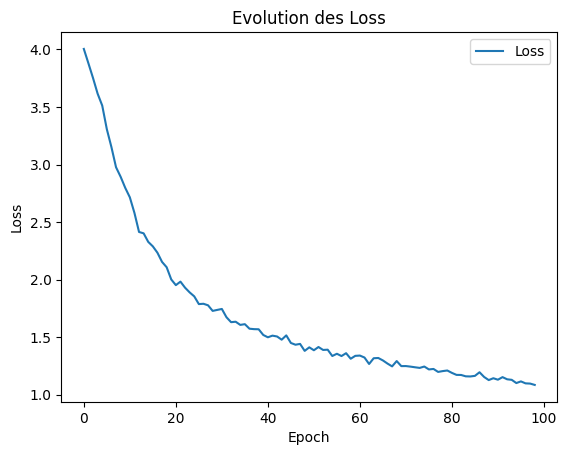

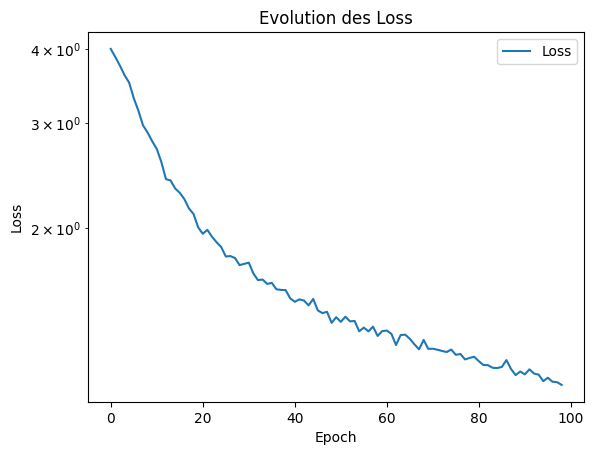

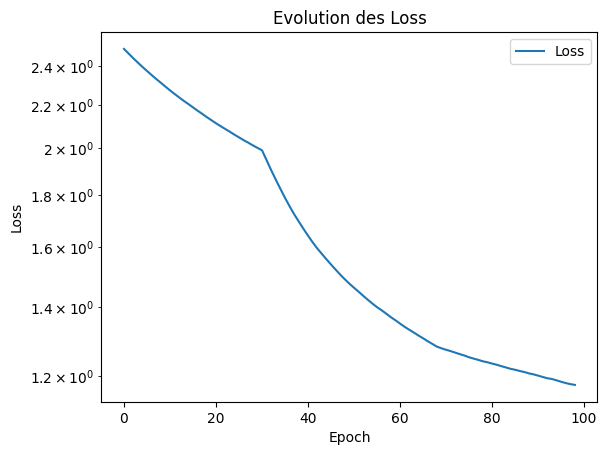

In [54]:
import matplotlib.pyplot as plt
def plot_loss(loss_list):
    plt.plot(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_loss_log(loss_list):
    plt.semilogy(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def running_mean(list,
                 half_window: int # Number of elements that the function will consider 
                                  # ahead and behind the pos X to calculate running mean at X.
                 ):

    running_means = []

    for i in range(0,len(list)):

        left_bound = max(0,i-half_window)
        right_bound = min(len(list)-1, i + half_window)
        sublist = list[left_bound:right_bound+1]
        running_means.append(sum(sublist)/len(sublist))

    return running_means

plot_loss(losses)
plot_loss_log(losses)
plot_loss_log(running_mean(losses, 30))

# Looking for embeddings

In [17]:
model_save_path = "TestComplEx"
loc_path = %pwd
torch.save(model.state_dict(), model_save_path)
print(f'Model saved at {loc_path}/{model_save_path}')

Model saved at /home/elliot/Desktop/StageM2/ESL2024/code/TestComplEx


ComplEx(8859, num_relations=8001, hidden_channels=30)

In [89]:
model.to('cpu')
torch.set_grad_enabled(False)

# Is model coherent ?
iric_first_line = iric.iloc[0].tolist()
map_tail = entity_to_mapping[iric_first_line[0]]
map_head = entity_to_mapping[iric_first_line[2]]
map_rel = relation_to_mapping[iric_first_line[1]]

print("Good score should appear here :")
print(model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head)))

print("Bad scores should appear here :")
print(model(torch.tensor(3307),torch.tensor(0),torch.tensor(4788)))
print(model(torch.tensor(3307),torch.tensor(0),torch.tensor(4378)))

['GO:0000001', 'is_a', 'GO:0048311']
Good score should appear here :
tensor(2.9489)
Bad scores should appear here :
tensor(0.2410)
tensor(-9.4802)


Attributs pour accéder aux embeddings :

        head_re = self.node_emb(head_index)
        head_im = self.node_emb_im(head_index)
        rel_re = self.rel_emb(rel_type)
        rel_im = self.rel_emb_im(rel_type)
        tail_re = self.node_emb(tail_index)
        tail_im = self.node_emb_im(tail_index)

In [72]:
entities_mapping_to_embedding = {}
relation_mapping_to_embedding = {}

for entity in entity_set:
    entity_id = entity_to_mapping[entity]

    real_part = model.node_emb(torch.tensor(entity_id))
    im_part = model.node_emb_im(torch.tensor(entity_id))

    embedding = torch.cat((real_part, im_part))

    entities_mapping_to_embedding[entity_id] = embedding

for relation in relation_set:
    relation_id = relation_to_mapping[relation]

    real_part = model.rel_emb(torch.tensor(relation_id))
    im_part = model.rel_emb_im(torch.tensor(relation_id))

    embedding = torch.cat((real_part, im_part))

    relation_mapping_to_embedding[relation_id] = embedding

In [83]:
print(relation_mapping_to_embedding[0])

tensor([-0.1546, -2.2084,  0.1792, -0.2003,  0.3402, -0.1695, -0.1181, -0.9837,
         0.0619, -0.0433, -0.4724,  0.2944,  0.8324, -0.0622,  0.1796,  1.2071,
        -0.1149,  0.2284, -0.1556, -0.5198,  0.0433, -0.9551,  0.2258,  0.6220,
         1.1284, -0.1425,  0.0780,  0.1810, -1.1671, -0.5129,  0.1879,  0.0305,
        -0.0604,  0.3088,  0.2583, -0.3503, -0.2150, -0.0229,  0.3299, -0.2128,
        -0.2301,  0.2068, -1.3932, -0.2077,  0.1553, -0.6298,  0.2253, -0.0216,
        -0.1473, -0.5450,  0.2370,  0.1822, -0.0687, -0.0309,  0.0064,  0.1553,
         0.1217, -0.4786,  0.0047,  0.2373])


# Preparing a dataset to investigate modified loss

## Making negative triples

On va créer n triplets négatifs par triplet positif.
Pour créer un triplet négatif à partir d'un triplet positif, on remplace la tête de ce dernier par une entité aléatoire.
Il y a une chance de créer des faux négatifs, mais comme chaque entité apparait moins d'une fois sur 1000 dans le jeu de données, cette probabilité reste faible.

In [100]:
# Nombre de triplets négatif par triplet positif :
n_negative_triplets_per_positive = 5

In [98]:
# Nombre d'apparition de chaque entité dans iric :
# mapped_iric.hist(column="subject", bins = len(list(entity_set)))

In [137]:
import numpy as np
from tqdm import tqdm
import random

def generate_negative_triples(df, number_of_false_per_true, falsify_relation = False):

    negative_triples = []

    possible_heads = list(set(list(df.iloc[:,0])))
    possible_relations = list(set(list(df.iloc[:,1])))
    possible_tails = list(set(list(df.iloc[:,2])))

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Negative Triples"):
        for i in range(number_of_false_per_true):

            if falsify_relation :
                r = np.random.randint(2) 
            else :
                r = np.random.randint(3)

            if r == 0:
                random_head = random.choice(possible_heads)
                negative_triples.append([random_head, row[1], row[2]])

            elif r == 1:
                random_tail = random.choice(possible_tails)
                negative_triples.append([row[0], row[1], random_tail])

            elif r == 2:
                random_relation = random.choice(possible_relations)
                negative_triples.append([row[0], random_relation, row[2]])



    negative_triples_df = pd.DataFrame(negative_triples, columns=df.columns)
    return pd.DataFrame(negative_triples_df)

negatives_from_iric = generate_negative_triples(mapped_iric, n_negative_triplets_per_positive)

Generating Negative Triples:   0%|          | 0/9999 [00:00<?, ?it/s]/tmp/ipykernel_91146/451501052.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negative_triples.append([random_head, row[1], row[2]])
/tmp/ipykernel_91146/451501052.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negative_triples.append([row[0], row[1], random_tail])
/tmp/ipykernel_91146/451501052.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negat

In [138]:
display(mapped_iric)
display(negatives_from_iric)
mapped_iric_with_negatives = pd.concat([mapped_iric, negatives_from_iric])
display(mapped_iric_with_negatives)

,subject,predicate,object
0,7284,0,7471
1,7284,0,4389
2,8475,0,6982
3,2172,0,2077
4,7666,0,1385
...,...,...,...
9994,5820,0,2066
9995,5820,0,6579
9996,7340,0,1958
9997,7596,0,8658


,subject,predicate,object
0,667,0,7471
1,7284,0,8058
2,2031,0,7471
3,7284,0,1897
4,7284,0,4389
...,...,...,...
39991,18,0,8658
39992,7964,0,1613
39993,7964,0,1137
39994,7964,0,6314


,subject,predicate,object
0,7284,0,7471
1,7284,0,4389
2,8475,0,6982
3,2172,0,2077
4,7666,0,1385
...,...,...,...
39991,18,0,8658
39992,7964,0,1613
39993,7964,0,1137
39994,7964,0,6314


In [139]:
shuffled_mapped_iric_with_negatives = mapped_iric_with_negatives.sample(frac=1)
display(shuffled_mapped_iric_with_negatives)

## From mapping to embedding

In [73]:
display(mapped_iric)

embedded_iric = mapped_iric.copy()
embedded_iric['object'] = embedded_iric['object'].apply(lambda x: entities_mapping_to_embedding[x])
embedded_iric['subject'] = embedded_iric['subject'].apply(lambda x: entities_mapping_to_embedding[x])
embedded_iric['predicate'] = embedded_iric['predicate'].apply(lambda x: relation_mapping_to_embedding[x])

display(embedded_iric)

print(embedded_iric['subject'][0])
print(embedded_iric['predicate'][0])

,subject,predicate,object
0,7284,0,7471
1,7284,0,4389
2,8475,0,6982
3,2172,0,2077
4,7666,0,1385
...,...,...,...
9994,5820,0,2066
9995,5820,0,6579
9996,7340,0,1958
9997,7596,0,8658


,subject,predicate,object
0,"[tensor(0.4543), tensor(0.1845), tensor(-1.491...","[tensor(-0.1546), tensor(-2.2084), tensor(0.17...","[tensor(-0.2860), tensor(0.3272), tensor(0.916..."
1,"[tensor(0.4543), tensor(0.1845), tensor(-1.491...","[tensor(-0.1546), tensor(-2.2084), tensor(0.17...","[tensor(0.3962), tensor(1.9241), tensor(0.1577..."
2,"[tensor(0.6450), tensor(0.5077), tensor(-0.057...","[tensor(-0.1546), tensor(-2.2084), tensor(0.17...","[tensor(-1.6022), tensor(-0.3235), tensor(-0.0..."
3,"[tensor(0.1716), tensor(-0.1435), tensor(-0.88...","[tensor(-0.1546), tensor(-2.2084), tensor(0.17...","[tensor(-1.0849), tensor(-0.4032), tensor(-1.0..."
4,"[tensor(1.0827), tensor(-0.8153), tensor(1.424...","[tensor(-0.1546), tensor(-2.2084), tensor(0.17...","[tensor(0.5453), tensor(0.4830), tensor(1.3297..."
...,...,...,...
9994,"[tensor(0.0543), tensor(-0.0218), tensor(-0.42...","[tensor(-0.1546), tensor(-2.2084), tensor(0.17...","[tensor(-1.1081), tensor(0.5387), tensor(-1.02..."
9995,"[tensor(0.0543), tensor(-0.0218), tensor(-0.42...","[tensor(-0.1546), tensor(-2.2084), tensor(0.17...","[tensor(-0.8206), tensor(-0.6930), tensor(-0.7..."
9996,"[tensor(-1.9039), tensor(0.5063), tensor(-0.47...","[tensor(-0.1546), tensor(-2.2084), tensor(0.17...","[tensor(-0.4288), tensor(-0.9841), tensor(-0.8..."
9997,"[tensor(1.8895), tensor(0.8978), tensor(0.3131...","[tensor(-0.1546), tensor(-2.2084), tensor(0.17...","[tensor(1.1877), tensor(0.1328), tensor(1.1624..."
